In [214]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import talib as ta
from datetime import datetime
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set()
from sklearn.metrics import accuracy_score, r2_score

In [215]:
def get_prices(ticker, start_date, end_date):
    start = datetime.strptime(start_date, '%d/%m/%Y')
    end = datetime.strptime(end_date, '%d/%m/%Y')
    f = web.DataReader(ticker, 'morningstar', start, end)
    df = pd.DataFrame(f)
    
    return df

## SQL Connection

In [216]:
from sqlalchemy import create_engine
import pandas as pd
from datetime import datetime

def create_connection():
    # Login details: 
    DSN_Name = 'traderDSN' ; Login_ID = 'basic' ; pwd = 'pwd1'

    # The engine does the same job as a connection and a cursor
    engine = create_engine(r'mssql+pyodbc://'+Login_ID+':'+pwd+'@'+ DSN_Name) 

    return engine 

# Build query here:
query = ''' 
SELECT * FROM {schema}.{table_name}

'''.format(schema='stocks', table_name='Adjusted_all_FTSE')
print('Query:', query)
print('='*60)


engine = create_connection()

# Importing a Pandas Dataframe: 
df1 = pd.read_sql(query,engine)

df1.head()

Query:  
SELECT * FROM stocks.Adjusted_all_FTSE




,index,open,high,low,close,adjusted close,volume,dividend amount,split coefficient,Name,Ticker
0,0,4.0500,4.0500,4.0300,4.0301,4.0301,2197,0.0000,1.0000,3i,III
1,0,4.0300,4.1600,4.0200,4.0400,4.0400,34942,0.0000,1.0000,3i,III
2,0,4.0800,4.0800,4.0000,4.0000,4.0000,52351,0.0000,1.0000,3i,III
3,0,4.1200,4.2000,4.0300,4.0900,4.0900,90139,0.0000,1.0000,3i,III
4,0,4.1310,4.1700,4.0950,4.1300,4.1300,49875,0.0000,1.0000,3i,III


In [317]:
prices = df1.copy()

prices = prices.drop(columns=['index','close', 'split coefficient','dividend amount'])
prices = prices.rename(columns={'Ticker':'symbol','adjusted close':'close','Name':'name'})
prices.head()

,open,high,low,close,volume,name,symbol
0,4.0500,4.0500,4.0300,4.0301,2197,3i,III
1,4.0300,4.1600,4.0200,4.0400,34942,3i,III
2,4.0800,4.0800,4.0000,4.0000,52351,3i,III
3,4.1200,4.2000,4.0300,4.0900,90139,3i,III
4,4.1310,4.1700,4.0950,4.1300,49875,3i,III


In [35]:
df1.shape

(329832, 11)

In [321]:
    #def stock_tester(ticker, start_date, end_date):
    engine = create_connection()
    query = ''' 
    SELECT * FROM {schema}.{table_name}
    '''.format(schema='stocks', table_name='Adjusted_all_FTSE_date')

    # Importing a Pandas Dataframe: 
    prices = pd.read_sql(query,engine)
    prices = prices.drop(columns=['index','close', 'split coefficient','dividend amount'])
    prices = prices.rename(columns={'Ticker':'symbol','adjusted close':'close','Name':'name'})

    
    # Reformat columns
    prices['open']  = prices['open'].astype(float)
    prices['high']  = prices['high'].astype(float)
    prices['low']   = prices['low'].astype(float)
    prices['close'] = prices['close'].astype(float)
    prices['volume']= prices['volume'].astype(float)

    prices['date'] = pd.to_datetime(prices['date'])

    prices.set_index(['symbol', 'name', 'date'], inplace=True)
    prices = prices.sort_index(level=1, ascending=True)

In [352]:
    # Calculated columns
    #prices['EMA_20'] = prices.groupby(level=1).apply(lambda x: ta.EMA(x.close.values, 20))  # 20 day exponential moving average
    prices['EMA_20'] = prices.groupby(level=0).apply(lambda x: 2*x)  # 20 day exponential moving average
    #     prices['EMA_50'] = prices.groupby(level=2).apply(lambda x: ta.EMA(x.close.values, 50))  # 50 day exponential moving average
    #     prices['EMA_200'] = prices.groupby(level=2).apply(lambda x: ta.EMA(x.close.values, 200))  # 200 day exponential moving average
    #     prices['EMA_ratio'] = prices['EMA_200']/prices['EMA_50'] # Ratio of moving average
    #     prices['RSI'] = prices.groupby(level=2).apply(lambda x: ta.RSI(x.close.values, 14))  # 14 day relative strength index
    #     prices['CCI'] = prices.groupby(level=2).apply(lambda x: ta.CCI(high=x.high.values, low=x.low.values, close=x.close.values, timeperiod=20))  # 20 day commodity channel index
    #     prices['Momentum'] = prices.groupby(level=2).apply(lambda x: ta.MOM(x.close.values, 10))  # 10 day rolling momentum
    #     #prices['Stoch_fastk'], prices['Stoch_fastd'] = prices.groupby(level=1).apply(lambda x: ta.STOCHF(high=x.high.values, low=x.low.values, close=x.close.values, fastk_period=14, fastd_period=3))  # Stochastic fast indicator
    #     prices['OBV'] = prices.groupby(level=2).apply(lambda x: ta.OBV(np.asarray(x['close']), x['volume']))  # On Balance Volume
    #     #prices['bbandupper'], prices['bbandmiddle'], prices['bbandlower'] =  prices.groupby(level=1).apply(lambda x: ta.BBANDS(x.close.values))
    #     prices['perc_change']=(prices['close']- prices['close'].shift(1))/prices['close'].shift(1)  # Getting the daily percentage change
    #     prices['5dayvol'] = prices['perc_change'].rolling(window=5, center=False).std()  # 5 day volatility 
    prices['7_day_target'] = prices['close'].shift(-7)/prices['close']  # target of X days
    
    #clean_prices = prices.loc[(prices['EMA_200'].notnull() & prices['7_day_target'].notnull())]
    #clean_prices = clean_prices.reset_index()
    
    forest = RandomForestRegressor()
    
    prices.head(50)

open  high   low   close    volume  EMA_20  \
symbol name date                                                     
III    3i   2007-02-12  7.35  7.50  7.35  7.1255  744900.0   14.70   
            2007-02-13  7.51  7.51  7.46  7.2028  518100.0   15.02   
            2007-02-14  7.47  7.47  7.40  7.1448   33100.0   14.94   
            2007-02-15  7.40  7.40  7.40  7.1448    7300.0   14.80   
            2007-02-16  7.41  7.41  7.41  7.1545   25700.0   14.82   
            2007-02-20  7.42  7.42  7.40  7.1641    4500.0   14.84   
            2007-02-21  7.43  7.43  7.43  7.1738    6000.0   14.86   
            2007-02-22  7.44  7.44  7.38  7.1448   14000.0   14.88   
            2007-02-23  7.44  7.44  7.39  7.1448   27100.0   14.88   
            2007-02-26  7.40  7.42  7.36  7.1448  123100.0   14.80   
            2007-02-27  7.40  7.40  7.40  7.1448       0.0   14.80   
            2007-02-28  7.39  7.39  7.39  7.1352     100.0   14.78   
            2007-03-01  7.39  7.42  7.34  7.0869     500.0   14.78   
            2007-03-02  7.31  7.32  7.26  7.0097   11600.0   14.62   
            2007-03-05  7.35  7.35  7.32  7.0772   29000.0   14.70   
            2007-03-06  7.38  7.41  7.38  7.1545   70300.0   14.76   
            2007-03-07  7.39  7.42  7.33  7.1641  112900.0   14.78   
            2007-03-08  7.40  7.42  7.39  7.1448  466200.0   14.80   
            2007-03-09  7.40  7.45  7.40  7.1931    4700.0   14.80   
            2007-03-12  7.45  7.45  7.42  7.1641   16000.0   14.90   
            2007-03-13  7.42  7.42  7.42  7.1641   50000.0   14.84   
            2007-03-14  7.40  7.45  7.35  7.1641  188000.0   14.80   
            2007-03-15  7.45  7.45  7.41  7.1545    5600.0   14.90   
            2007-03-16  7.44  7.44  7.42  7.1738    1800.0   14.88   
            2007-03-19  7.44  7.44  7.40  7.1641   67900.0   14.88   
            2007-03-20  7.42  7.44  7.40  7.1448  152100.0   14.84   
            2007-03-21  7.45  7.45  7.40  7.1931   47600.0   14.90   
            2007-03-22  7.45  7.49  7.42  7.1931   55500.0   14.90   
            2007-03-23  7.45  7.49  7.40  7.2221   36000.0   14.90   
            2007-03-26  7.45  7.45  7.45  7.1931     900.0   14.90   
            2007-03-27  7.42  7.44  7.41  7.1545   66400.0   14.84   
            2007-03-28  7.45  7.45  7.45  7.1931    5100.0   14.90   
            2007-03-29  7.41  7.62  7.38  7.2800  274800.0   14.82   
            2007-03-30  7.54  7.60  7.43  7.2028  626100.0   15.08   
            2007-04-02  7.47  7.52  7.40  7.2221  179400.0   14.94   
            2007-04-03  7.43  7.45  7.43  7.1931   58500.0   14.86   
            2007-04-04  7.45  7.45  7.40  7.1448  119600.0   14.90   
            2007-04-05  7.41  7.43  7.39  7.1738   73700.0   14.82   
            2007-04-09  7.42  7.55  7.41  7.1641   83600.0   14.84   
            2007-04-10  7.41  7.51  7.41  7.1931  310100.0   14.82   
            2007-04-11  7.46  7.50  7.44  7.2028  638200.0   14.92   
            2007-04-12  7.44  7.50  7.41  7.2414  149900.0   14.88   
            2007-04-13  7.49  7.49  7.40  7.1931  164800.0   14.98   
            2007-04-16  7.49  7.50  7.44  7.1931   37800.0   14.98   
            2007-04-17  7.44  7.50  7.43  7.2221   53500.0   14.88   
            2007-04-18  7.45  7.46  7.42  7.1641   36700.0   14.90   
            2007-04-19  7.41  7.45  7.41  7.1834   54200.0   14.82   
            2007-04-20  7.44  7.55  7.41  7.2221   95000.0   14.88   
            2007-04-23  7.47  7.47  7.40  7.1545   12500.0   14.94   
            2007-04-24  7.40  7.48  7.40  7.2124   35400.0   14.80   

                        7_day_target  
symbol name date                      
III    3i   2007-02-12      1.002709  
            2007-02-13      0.991948  
            2007-02-14      1.000000  
            2007-02-15      1.000000  
            2007-02-16      0.997302  
            2007-02-20      0.989224  
            2007-02-21      0.977125  
            2007-02-22      0.99

In [345]:
prices.close.values()

array([  7.1255,   7.2028,   7.1448, ..., 131.32  , 131.32  , 131.77  ])

In [300]:
    #x_train, x_test, y_train, y_test = train_test_split(clean_prices.loc[:,'EMA_ratio':'bbandlower'], clean_prices.loc[:,['7_day_target']], shuffle=False, test_size=90)
    test_size = 3
    # Get columns
    X = clean_prices.copy().loc[:,'EMA_ratio':'bbandlower'] 
    y = clean_prices.copy().loc[:, ['7_day_target']]
    
    X.min()

EMA_ratio     NaN
RSI           NaN
CCI           NaN
Momentum      NaN
Stoch_fastk   NaN
Stoch_fastd   NaN
OBV           NaN
bbandupper    NaN
bbandmiddle   NaN
bbandlower    NaN
dtype: float64

In [261]:
    # Get series of ingroup rownumbers
    X['num']= X.groupby(level=1).cumcount(ascending=False)

In [269]:
    # Filter
    X_train = X.loc[X.num > test_size ].drop(columns='num')
    X_test =  X.loc[X.num <= test_size ].drop(columns='num')
    y_train = y.loc[X.num > test_size ]
    y_test =  y.loc[X.num <= test_size ]
    
    X_test.head(40)

EMA_ratio        RSI         CCI  \
symbol name                     date                                           
III    3i                       2018-05-14   0.972111  42.139518 -116.099630   
                                2018-05-15   0.973847  37.888095 -159.932184   
                                2018-05-16   0.975245  40.749246 -113.179959   
                                2018-05-17   0.976184  44.852845  -94.290674   
ADM    Admiral Group            2018-05-14   0.964404  50.804636  -47.207538   
                                2018-05-15   0.964456  50.687932  -35.247024   
                                2018-05-16   0.964237  55.589598  -16.237097   
                                2018-05-17   0.963795  59.424679   23.587186   
AAL    Anglo American plc       2018-05-14   1.039867  38.288131  -51.080468   
                                2018-05-15   1.041982  42.423480  -41.817860   
                                2018-05-16   1.043413  46.983199   20.400851   
                                2018-05-17   1.045052  45.082831   25.866538   
AHT    Ashtead Group            2018-05-14   0.947255  51.308930    2.505096   
                                2018-05-15   0.947355  47.312770 -121.509908   
                                2018-05-16   0.947551  46.532189 -145.521096   
                                2018-05-17   0.947758  46.532189 -115.008499   
ABF    Associated British Foods 2017-08-23   1.193755  71.268846  133.333333   
                                2017-08-24   1.029427  71.268846  111.111111   
                                2017-08-25   0.918556  71.268846   95.238095   
                                2017-08-28   0.839154  71.268846   83.333333   
AZN    AstraZeneca              2018-05-14   0.947515  60.111968  177.426695   
                                2018-05-15   0.947295  57.288118  105.644052   
                                2018-05-16   0.946908  60.196725  149.469771   
                                2018-05-17   0.946608  59.194920  124.009669   
BA     BAE Systems              2018-05-14   0.879159  57.522302  123.658691   
                                2018-05-15   0.879743  55.191253   66.914050   
                                2018-05-16   0.880430  54.092158   57.493315   
                                2018-05-17   0.880897  56.654600   74.636202   
BLT    BHP                      2016-04-15   0.960361  69.304186   84.441874   
                                2016-04-18   0.959894  69.304186   78.674948   
                                2016-04-19   0.959466  69.304186   73.153899   
                                2016-04-20   0.959077  69.304186   68.910256   
BP     BP                       2018-05-14   0.919656  74.284445  151.368696   
                                2018-05-15   0.917848  76.007968  145.776333   
                                2018-05-16   0.916225  74.899030  125.300800   
                                2018-05-17   0.914438  77.061496  138.506406   
BTA    BT Group                 2018-05-14   1.009496  52.582326  -15.137980   
                                2018-05-15   1.009569  46.389104  -85.263671   
                                2018-05-16   1.009699  44.401814  -90.695394   
                                2018-05-17   1.009781  45.887569 -102.103795   

                                            Momentum  Stoch_fastk  \
symbol name                     date                                
III    3i                       2018-05-14   -0.2500    27.142857   
                                2018-05-15   -0.2800    14.285714   
                                2018-05-16   -0.2900    20.000000   
                                2018-05-17   -0.0400    28.571429   
ADM    Admiral Group            2018-05-14   -0.9529    25.671848   
                                2018-05-15   -0.6154    25.329879   
                                2018-05-16    0.4218    40.587219   
                                2018-05-17    1.6356    55.202

In [272]:
    tree.fit(X_train,y_train)
    y_pred = tree.predict(X_test)
    y_pred = pd.DataFrame({'ans': y_pred})
    test = pd.DataFrame({'close':clean_prices.tail(90).reset_index().close, 'ratio':y_pred['ans']})
    test['pred_price']= test['close'] * test['ratio']

#     fig, ax1 = plt.subplots(figsize=(18,8))

#     ax1.plot(y_pred['ans'], color='tab:blue')
#     ax1.tick_params(labelrotation=85)
#     ax1.grid(True)
#     ax2 = ax1.twiny()
#     ax2.plot(y_test['7_day_target'], color='tab:red')
#     ax2.grid(True)

#     fig, axa = plt.subplots(figsize=(18,8))
#     axa.plot(clean_prices['close'].tail(90))

#     axb = axa.twiny()
#     axb.plot(test['pred_price'], color='tab:red')

    #eturn tree.feature_importances_

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

C:\Users\Student\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).std()
C:\Users\Student\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


array([0.19176396, 0.07009146, 0.14725075, 0.08071336, 0.04819533,
       0.08141017, 0.13955625, 0.09373079, 0.06605477, 0.08123315])

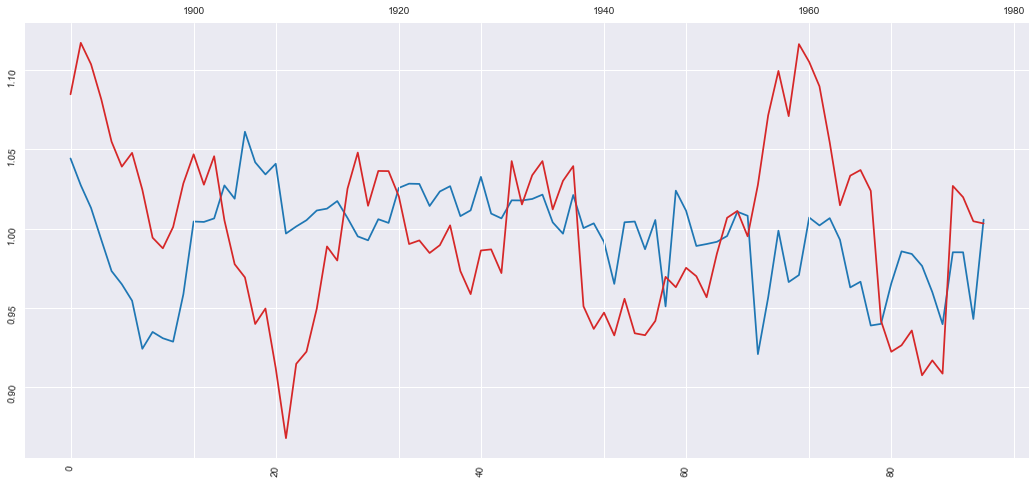

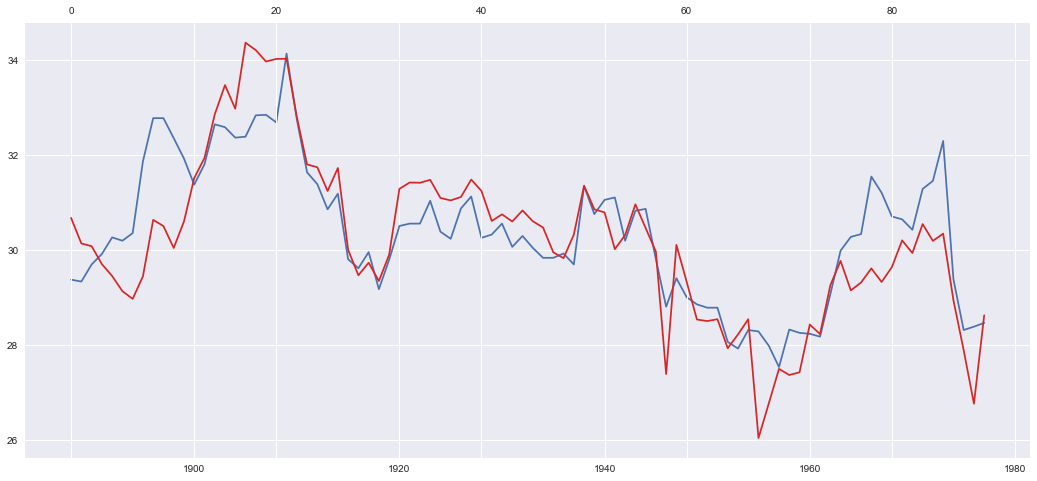

In [71]:
stock_tester('XRX', '01/01/2010', '16/05/2018')

In [48]:
prices

In [327]:
df1 = pd.DataFrame(list(range(20)))

In [333]:
# Some companies are missing recent data. 
def EMA(x, alpha=0.8):
    em = alpha*x.shift(1)*(1-alpha)*x
    return em
    
df1.apply(EMA)
            

,0
0,NaN
1,0.00
2,0.32
3,0.96
4,1.92
5,3.20
6,4.80
7,6.72
8,8.96
9,11.52
